# Optimisation: First example

This example shows you how to run a global optimisation with Pints.

First, we import pints:

In [1]:
import pints

Next, we need a model: any class that implements the [pints.ForwardModel interface](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#forward-model).

Usually, you'd write a class for this purpose (that wrapped around whatever simulation package you wanted to use to generate your time series data). But you could also use a pure-Python model.

In the example, we use a logistic model (https://en.wikipedia.org/wiki/Logistic_function), provided by [http://pints.readthedocs.io/en/latest/toy/index.html](Pints's toy model module).

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

This model has two parameters: A growth rate (which determines the steepness of the curve) and a carrying capacity (which determines the number the curve converges to).
For the example, we simply pick some nice values:

In [3]:
real_parameters = [0.015, 500]

Finally, we create a list of times (in a real experiment, these would be the times at which the time series was sampled)

In [4]:
import numpy as np
times = np.linspace(0, 1000, 1000)

We now have everything we need to run a simulation and generate some toy data:

In [5]:
values = model.simulate(real_parameters, times)

We can use Matplotlib (or any other plotting package) to have a look at the generated data:

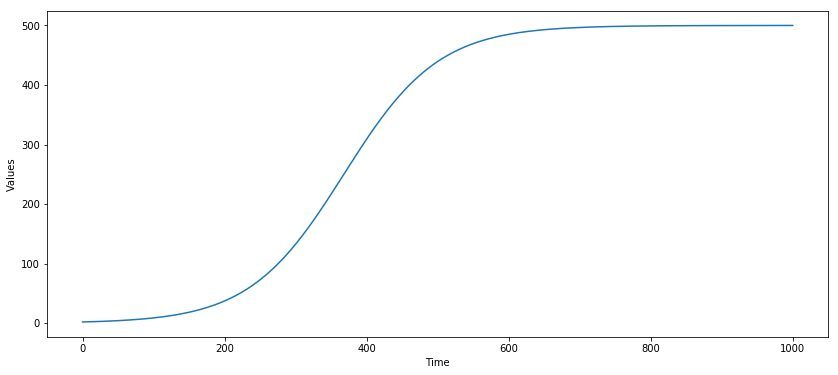

In [6]:
import matplotlib.pyplot as pl

pl.figure(figsize=(14, 6))
pl.xlabel('Time')
pl.ylabel('Values')
pl.plot(times, values)
pl.show()

If you like, you can make it more realistic at this point by adding some noise:

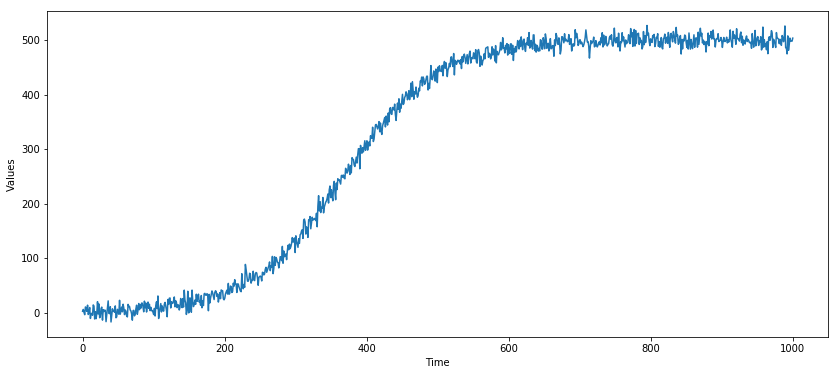

In [7]:
values += np.random.normal(size=values.shape) * 10

pl.figure(figsize=(14, 6))
pl.xlabel('Time')
pl.ylabel('Values')
pl.plot(times, values)
pl.show()

We now set up an optimisation, to see if we can recover our original parameters from this data.

First, we define a problem (in this case a [single time series fitting problem](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#single-series-problem)):

In [8]:
problem = pints.SingleSeriesProblem(model, times, values)

We then define a [score function](http://pints.readthedocs.io/en/latest/error_measures.html) on this problem:

In [9]:
score = pints.SumOfSquaresError(problem)

A lot of real problems have physical constraints on the values the parameters can take, so in this example we add them in the form of [boundaries](http://pints.readthedocs.io/en/latest/boundaries.html):

In [10]:
boundaries = pints.Boundaries([0, 200], [1, 1000])

We now run an optimisation, using the [xNES](http://pints.readthedocs.io/en/latest/optimisers/xnes.html) method (although we could also have used a different global [optimiser](http://pints.readthedocs.io/en/latest/optimisers/index.html), like [CMA-ES](http://pints.readthedocs.io/en/latest/optimisers/cmaes.html) or [PSO](http://pints.readthedocs.io/en/latest/optimisers/pso.html)):

In [11]:
found_parameters, found_value = pints.xnes(
    score,
    boundaries,
    )

Running in parallel mode with population size 8
1: 57473736.1033
2: 40492632.6644
3: 40413887.8285
20: 20121659.6602
40: 5458498.33658
60: 94821.6027402
80: 94289.2626597
100: 94289.2528956
120: 94289.2528945
140: 94289.2528945
160: 94289.2528945
180: 94289.2528945
200: 94289.2528945
220: 94289.2528945
240: 94289.2528945
Halting: No significant change for 100 iterations.
244: 94289.2528945


In our toy model example, we can compare the parameters with the known true parameters:

In [12]:
print('Score at true solution: ')
print(score(real_parameters))

print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Score at true solution: 
94542.7476996
Found solution:          True parameters:
 1.49922140675286183e-02     1.49999999999999994e-02
 5.00755255420418223e+02     5.00000000000000000e+02


And we can also plot the score between the found solution and the true parameters.

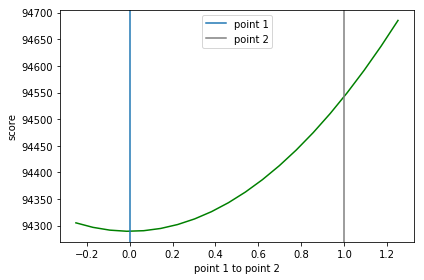

In [13]:
import pints.plot
fig, axes = pints.plot.log_likelihood_two_points(score, 
                                                 found_parameters, 
                                                 real_parameters)
axes.set_ylabel('score')
pl.show()

In real life, we might compare the fit by running a simulation and comparing with the data:

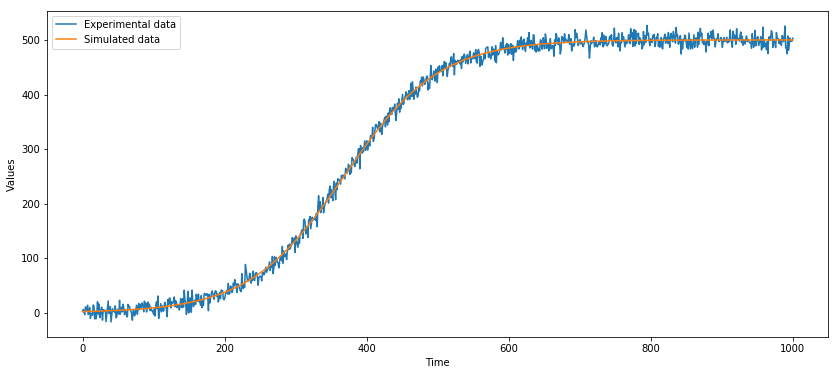

In [14]:
values2 = model.simulate(found_parameters, times)

pl.figure(figsize=(14, 6))
pl.xlabel('Time')
pl.ylabel('Values')
pl.plot(times, values, label='Experimental data')
pl.plot(times, values2, label='Simulated data')
pl.legend()
pl.show()